In [1]:
library(tidyverse)
library(lubridate)
library(magrittr)

investigate_id <- function(id, t) {
  # t is a tibble, id is an auction number on ebay
  # easier to investigate an auction
  #auctions <- camera_named %>%
    auctions <- t %>%
    filter(item_id == id) %>% 
    arrange(desc(bid_time))
  #rank(bid_time)
    #scale_x_continuous(breaks = seq_along(auctions)) +
  p <- ggplot(auctions, aes(x = bid_time, y = bid_price)) +
    geom_hline(aes(yintercept =  mean(buy_it_now), colour = 'BIN price'), alpha = 0.5, size = 2) +
    geom_hline(aes(yintercept =  mean(reserve_price), colour = 'reserve price')) +
    geom_hline(aes(yintercept =  max(bid_price), colour = 'highest price')) +
    scale_colour_manual(values = c("blue", "red", "green")) +
    geom_point() +
    scale_x_datetime(breaks = seq_along(auctions$bid_time), limits=c(min(auctions$bid_time),max(auctions$bid_time))) +
    labs(
      title = paste("Investigation for the auction of item #", id, sep = ""),
      x = "Time of Bid",
      y = "Bid price"
    )
  print(p)
  
  invisible(auctions)
}

#R.Version()

Warning message:
“package ‘tidyverse’ was built under R version 3.6.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.1     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”
Warning message:
“package ‘tibble’ was built under R version 3.6.3”
Warning message:
“package ‘tidyr’ was built under R version 3.6.3”
Warning message:
“package ‘readr’ was built under R version 3.6.3”
Warning message:
“package ‘purrr’ was built under R version 3.6.3”
Warning message:
“package ‘dplyr’ was built under R version 3.6.3”
Warning message:
“package ‘stringr’ was built under R version 3.6.3”
Warning message:
“package ‘forcats’ was built under R version 3.6.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
camera <- read_tsv("camera.txt", col_names = FALSE, col_types = 
                     cols(
                       X1 = col_integer(),
                       X2 = col_integer(),
                       X3 = col_character(),
                       X4 = col_character(),
                       X5 = col_double(),
                       X6 = col_character(),
                       X7 = col_double(),
                       X8 = col_integer(),
                       X9 = col_character(),
                       X10 = col_double(),
                       X11 = col_integer(),
                       X12 = col_logical(),
                       X13 = col_logical(),
                       X14 = col_logical(),
                       X15 = col_character(),  # use lubridate to parse them later
                       X16 = col_character(), 
                       X17 = col_character()
                     ))
#head(camera, n=10)

In [3]:
camera_named <- camera %>% 
  mutate(X15 = ymd_hms(X15) + years(5), # should be in year 2005
         X16 = ymd_hms(X16) + years(5),
         X17 = ymd_hms(X17) + years(5)
         ) %>% 
  rename(bid_id = X1, 
         item_id = X2, 
         product = X3, 
         model = X4, 
         buy_it_now = X5,    
         seller = X6, 
         reserve_price = X7, 
         seller_feedback = X8, 
         bidder = X9, 
         bid_price = X10, 
         buyer_feedback = X11,
         X12 = X12,
         X13 = X13,
         X14 = X14,
         bid_time = X15,
         start_time = X16,
         end_time = X17) %>% 
  filter(!is.na(bid_time)) # get rid of invalid bids
#head(camera_named,n=10)

Warning message:
“ 1577 failed to parse.”


In [4]:
sub_camera <- camera_named %>% select(item_id,buy_it_now,bidder,bid_price,reserve_price,bid_time,start_time,end_time)
sub_camera

item_id,buy_it_now,bidder,bid_price,reserve_price,bid_time,start_time,end_time
<int>,<dbl>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dttm>
295255148,252.0,bluej8,252.0,10,2005-04-07 16:51:38,2005-03-28 15:53:25,2005-04-07 16:53:25
295255148,252.0,vlfields,249.5,10,2005-04-07 15:16:22,2005-03-28 15:53:25,2005-04-07 16:53:25
295255148,252.0,tsboise@aol.com,245.0,10,2005-04-07 14:10:09,2005-03-28 15:53:25,2005-04-07 16:53:25
295255148,252.0,acm1546,225.0,10,2005-04-06 18:10:12,2005-03-28 15:53:25,2005-04-07 16:53:25
295255148,252.0,golf2671@aol.com,217.0,10,2005-04-06 19:48:37,2005-03-28 15:53:25,2005-04-07 16:53:25
295255148,252.0,g.i.s,200.0,10,2005-04-06 17:44:33,2005-03-28 15:53:25,2005-04-07 16:53:25
295255148,252.0,flexbt,162.5,10,2005-04-03 07:31:27,2005-03-28 15:53:25,2005-04-07 16:53:25
295255148,252.0,feagles@citlink.net,160.0,10,2005-04-01 09:51:52,2005-03-28 15:53:25,2005-04-07 16:53:25
295255148,252.0,maddiesmama,150.0,10,2005-04-02 10:38:50,2005-03-28 15:53:25,2005-04-07 16:53:25


In [5]:
sub_camera <- camera_named %>% 
  select(item_id,buy_it_now,bidder,bid_price,reserve_price,bid_time,start_time,end_time)


In [13]:
item_ids <- sub_camera %>% group_by(item_id) %>% 
 summarize( highest_bid = max(bid_price),
              selling_price = median(buy_it_now))
#table(item_ids$selling_price < item_ids$highest_bid)
ids_greater <- item_ids %>% filter(highest_bid > selling_price)
ids_greater

`summarise()` ungrouping output (override with `.groups` argument)



item_id,highest_bid,selling_price
<int>,<dbl>,<dbl>
299720418,15.00,14.99
299720722,15.99,14.99
299721429,17.01,16.99
300278330,270.00,265.00
301284833,9.50,8.50
302056583,655.00,650.00
302428265,330.00,294.00
302779105,581.03,580.01
303004511,9.02,9.00


In [6]:
#filter(sub_camera,item_id == 324903140 )

In [7]:
#filter(camera_named,item_id == 324903140 )

[1] 18773

`summarise()` ungrouping output (override with `.groups` argument)



mean
<dbl>
9.457156


`summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 18,772 x 2
   bidder                 n
   <chr>              <int>
 1 jkhorvath9@aol.com   154
 2 nosurprisesplease    154
 3 tvannie              118
 4 rwernet               99
 5 n7734r                95
 6 marylandpride         94
 7 buyhi-sello           68
 8 euron@go.com          63
 9 geving                61
10 decochic              56
# … with 18,762 more rows


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



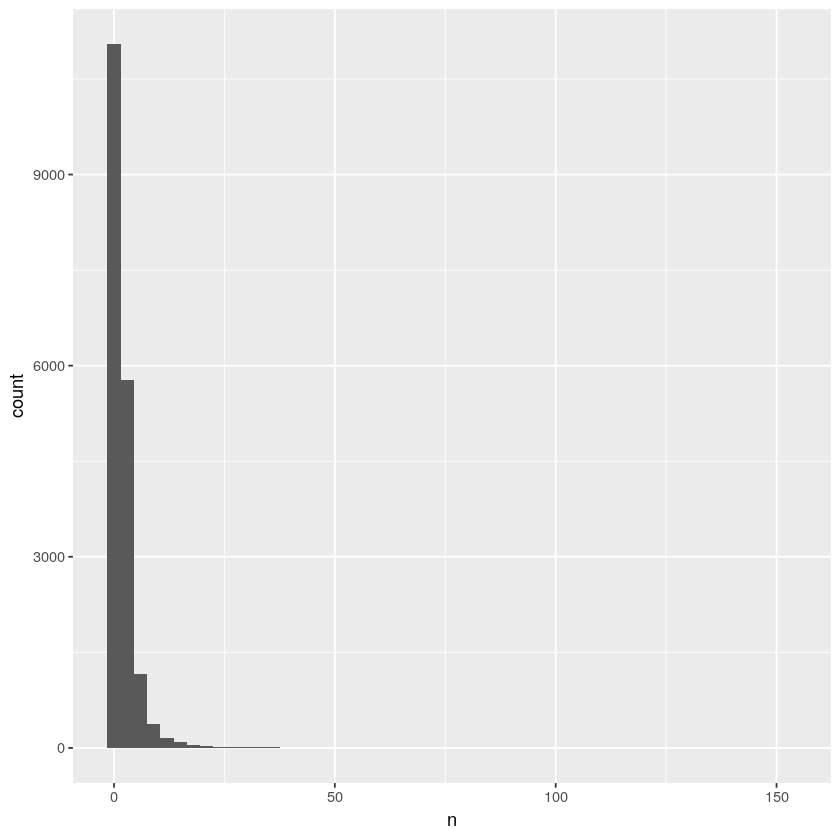

ERROR: Error in eval(lhs, parent, parent): object 'trades' not found


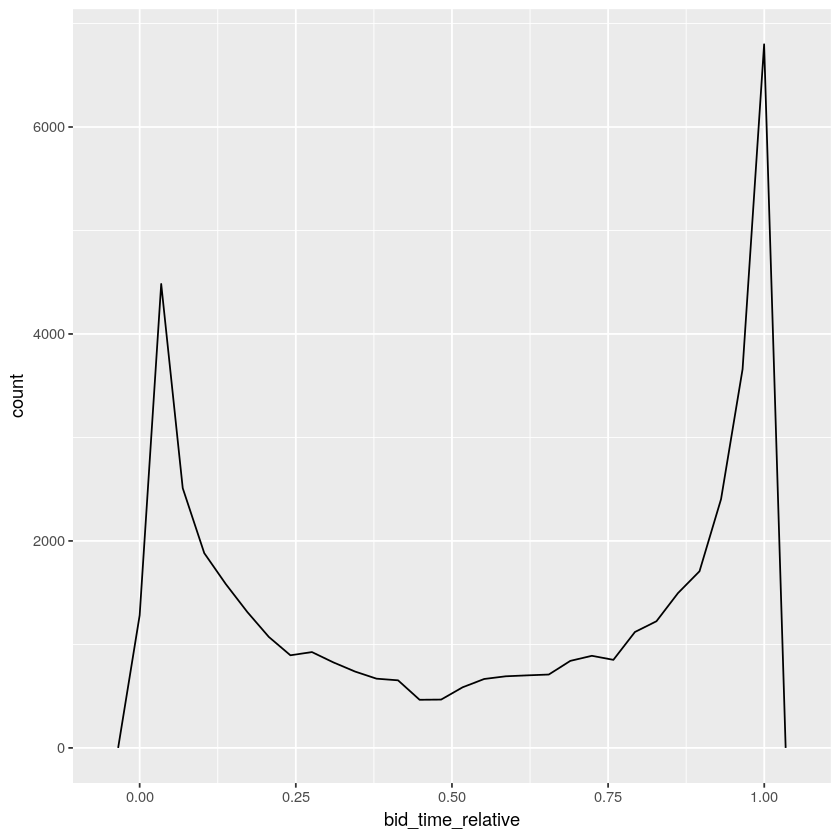

In [8]:
#nrow(auctions) 

# 2) number of bidders: 18773, number of sellers: 1199
length(unique(camera_named$bidder))
# 3) average number of bidders per trade: 9.46
camera_named %>%  
  group_by(item_id) %>% 
  summarize(n = n_distinct(bidder, na.rm = TRUE)) %>% 
  summarize(mean = mean(n))

# The average number of bidders is substantially higher than (number of bidders) / (number of trades) 18773 / 4388 = 4.278259
# This means some of the bidders are very active

# 4) how active are the bidders
camera_named %>%  # the most active bidder bids 154 times
  filter(!is.na(bidder)) %>% 
  group_by(bidder) %>% 
  summarize(n = n()) %>% 
  arrange(desc(n)) %T>% 
  print() %>% 
  ggplot(aes(x = n)) +
  geom_histogram(binwidth = 3)

# 5) bid time distribution: very large of bids occurs near the ends and right after the starts
camera_named %>% 
  mutate(bid_time_relative = as.duration(bid_time - start_time) / as.duration(end_time - start_time)) %>% 
  ggplot(aes(x = bid_time_relative)) +
  geom_freqpoly()

# 6) transaction price (highest price) distribution: 
#           for cameras, the prices are more diverse than expected, especially for the lower ranges
#           also, the distribution of the highest bids is very close to the distribution of the buy it now prices
trades %>% 
  ggplot() +
  geom_freqpoly(aes(x = buy_it_now), colour = 'red') +
  geom_freqpoly(aes(x = highest_bid), colour = 'blue')

